<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/EN/S08_09_Retail_Analytics/S8_Module1A_Cereal_Demand_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 8: Retail analytics - Predictive Model Training
---
*Yossiri Adulyasak*

---

# Module 1A: Retail predictive model pipeline for multiple items

This is the full version of the Module 1 (predictive model) for session 8 which extend the simplified version of one item to multiple items.

We begin by loading the required packages.

In [1]:
import pandas as pd  # Library for data manipulation (DataFrames)
import numpy as np   # Library for numerical operations (needed for square roots, etc.)

# Import specific machine learning models
import xgboost as xgb        # XGBoost: Optimized Gradient Boosting library
import lightgbm as lgb       # LightGBM: Another high-performance Gradient Boosting library
from sklearn.linear_model import LinearRegression  # Basic Linear Regression
from sklearn.ensemble import RandomForestRegressor # Random Forest (ensemble of trees)

# Import metrics to measure how "wrong" our predictions are
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error



## *Custom function - Error calculations

First, we create a function to measure the quality of predictions

In [2]:
def evaluate_model(model_name, y_true, y_pred):
    # MAE: Average absolute difference. Easy to interpret (e.g., "off by 20 units").
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE: Root Mean Squared Error. Penalizes large errors more than MAE.
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE: Mean Absolute Percentage Error. Shows error as a % of actual sales.
    # We use numpy (np) to calculate: mean( abs( (Actual - Pred) / Actual ) ) * 100
    mape = np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

    # wMAPE: Weighted MAPE. Sum of Absolute Errors divided by the Sum of Actual Values
    wmape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

    # R2: How well the model explains the variance. 1.0 is perfect, 0.0 is useless.
    r2 = r2_score(y_true, y_pred)

    # Print the formatted results
    print(f"{model_name:18} | MAE: {mae:6.2f} | RMSE: {rmse:6.2f} | MAPE: {mape:6.2f}% | wMAPE: {wmape:6.2f}% | R2: {r2:.4f}")

# Block 1: Data input

In [3]:
# -------------------------------------------------------------------------
# LOAD AND PREPARE DATA
# -------------------------------------------------------------------------
URL = 'https://raw.githubusercontent.com/acedesci/scanalytics/refs/heads/master/EN/S08_09_Retail_Analytics/data/cereals_data_full.csv'
df = pd.read_csv(URL)
# Drop any rows that have missing values (NaN).
df = df.dropna()

# Calculate the discount column from 'BASE_PRICE' and 'PRICE'
df['DISCOUNT'] = (df['BASE_PRICE'] - df['PRICE']) / df['BASE_PRICE']

# Convert the 'WEEK_END_DATE' column from string format to a datetime object. This allows us to sort the data chronologically.
df['WEEK_END_DATE'] = pd.to_datetime(df['WEEK_END_DATE'])

# Extract Week Number (1-53) to capture seasonality
df['WEEK_NUM'] = df['WEEK_END_DATE'].dt.isocalendar().week.astype(int)

# Sort the dataset by date. This is CRITICAL for time-series splits as we want to train on the "past" and test on the "future".
df = df.sort_values('WEEK_END_DATE')
df

,WEEK_END_DATE,STORE_NUM,UPC,UNITS,VISITS,HHS,SPEND,PRICE,BASE_PRICE,FEATURE,DISPLAY,TPR_ONLY,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE,DISCOUNT,WEEK_NUM
0,2009-01-14,367,1111085319,14,13,13,26.32,1.88,1.88,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.000000,3
457,2009-01-14,21213,3800039118,32,31,31,86.08,2.69,3.32,1,1,0,KELLOGG,COLD CEREAL,KIDS CEREAL,12 OZ,0.189759,3
458,2009-01-14,21221,1111085319,15,13,13,28.20,1.88,1.88,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.000000,3
459,2009-01-14,21221,1111085345,35,30,29,65.45,1.87,1.87,0,0,0,PRIVATE LABEL,COLD CEREAL,ADULT CEREAL,18 OZ,0.000000,3
460,2009-01-14,21221,1111085350,71,53,52,139.16,1.96,1.96,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,18 OZ,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138178,2012-01-04,10019,1111085345,17,12,12,27.54,1.62,1.62,0,0,0,PRIVATE LABEL,COLD CEREAL,ADULT CEREAL,18 OZ,0.000000,1
138179,2012-01-04,10019,1111085350,4,3,3,8.88,2.22,2.22,0,0,0,PRIVATE LABEL,COLD CEREAL,ALL FAMILY CEREAL,18 OZ,0.000000,1
138180,2012-01-04,10019,1600027527,82,71,71,163.18,1.99,2.68,0,0,1,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.257463,1
138182,2012-01-04,10019,1600027564,17,16,16,51.34,3.02,3.02,0,0,0,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ,0.000000,1


# Block 2: Data preparation

We need to select the features and split the data. Some input features will be transformed later since some models (linear regression and random forest) use dummy encoding while advanced models (XGBoost and LightGBM) simply require the column to be in categorical type (no need to transform the variable).

In [4]:
# Get a list of all unique weeks in the dataset
unique_weeks = df['WEEK_END_DATE'].unique()

# Calculate the index for the 80% mark.
# We will use the first 80% of weeks for training, last 20% for testing.
split_idx = int(len(unique_weeks) * 0.8)

# Identify the specific date that separates train and test
split_date = unique_weeks[split_idx]

print(f"Splitting data at date: {split_date}")

# Create "Masks" (lists of True/False values) to filter the data.
# train_mask is True for all dates BEFORE the split date.
train_mask = df['WEEK_END_DATE'] < split_date
# test_mask is True for all dates ON or AFTER the split date.
test_mask = df['WEEK_END_DATE'] >= split_date

# --------------------------------------------------------------------------------
# DEFINE TARGET AND FEATURES
# --------------------------------------------------------------------------------
# The column we want to predict
target = 'UNITS'

# List of columns to remove from the input features (X).
# - 'UNITS': This is the answer (target), so we can't use it to predict itself.
# - 'WEEK_END_DATE': The model doesn't understand dates directly, and we used it for splitting. We will use 'WEEK_NUM' instead.
# - 'SPEND', 'VISITS', 'HHS': These are "Data Leakage". They only exist *after* sales happen.
# - 'UPC' can be dropped if we want to demonstrate the attribute-based predictive model (e.g., when the model can be used for a new product)

# change here if we want to use UPC feature or attribute features (without UPC)
with_UPC = False

if with_UPC:
  # with UPC and no product attributes
  feature_cols = ['STORE_NUM', 'UPC', 'PRICE', 'DISCOUNT', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'WEEK_NUM']
  categorical_columns = ['STORE_NUM', 'UPC', 'WEEK_NUM']
else:
# without UPC but with product attributes
  feature_cols = ['STORE_NUM', 'PRICE', 'DISCOUNT', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE', 'WEEK_NUM']
  categorical_columns = ['STORE_NUM', 'MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE', 'WEEK_NUM']

# Create the Feature Matrix (X) from selected columns
X = df[feature_cols]

# Create the Target Vector (y) containing only the thing we want to predict
y = df[target]

X

Splitting data at date: 2011-06-01 00:00:00


,STORE_NUM,PRICE,DISCOUNT,FEATURE,DISPLAY,TPR_ONLY,MANUFACTURER,SUB_CATEGORY,PRODUCT_SIZE,WEEK_NUM
0,367,1.88,0.000000,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,3
457,21213,2.69,0.189759,1,1,0,KELLOGG,KIDS CEREAL,12 OZ,3
458,21221,1.88,0.000000,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,3
459,21221,1.87,0.000000,0,0,0,PRIVATE LABEL,ADULT CEREAL,18 OZ,3
460,21221,1.96,0.000000,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,18 OZ,3
...,...,...,...,...,...,...,...,...,...,...
138178,10019,1.62,0.000000,0,0,0,PRIVATE LABEL,ADULT CEREAL,18 OZ,1
138179,10019,2.22,0.000000,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,18 OZ,1
138180,10019,1.99,0.257463,0,0,1,GENERAL MI,ALL FAMILY CEREAL,12 OZ,1
138182,10019,3.02,0.000000,0,0,0,GENERAL MI,ALL FAMILY CEREAL,12 OZ,1


# Block 3: Model & algorithm (training & testing)

In the next code cell, we train and test two different types of models, namely Linear Regression and Tree Regression. These models use all the selected features where the categorial variables (STORE_NUM and UPC) are first transformed into dummy variables. We train each model and test its performance on unseen data (test).

### Linear regression and random forest models

In [5]:
# --------------------------------------------------------------------------------
# MODEL GROUP A: ONE-HOT/DUMMY ENCODING (For Linear Reg & Random Forest)
# --------------------------------------------------------------------------------
# Convert categorical IDs (STORE_NUM, UPC) into binary columns (0 or 1).
# Example: STORE_367 becomes a column. 1 if it's store 367, 0 otherwise.
# drop_first=True removes the first category (dummy encoding) to prevent multicollinearity
X_ohe = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Apply the time-based masks to split the One-Hot Encoded data
X_train_ohe = X_ohe[train_mask] # Past data
X_test_ohe = X_ohe[test_mask]   # Future data
y_train = y[train_mask]         # Past targets
y_test = y[test_mask]           # Future targets

# --- Model 1: Linear Regression ---
lr = LinearRegression()         # Initialize the model
lr.fit(X_train_ohe, y_train)    # Train on the past data
pred_lr = lr.predict(X_test_ohe)   # Predict the future data
evaluate_model("Linear Regression", y_test, pred_lr) # Measure performance

# --- Model 2: Random Forest ---
# n_estimators=50: Build 50 trees (more is usually better but slower)
# max_depth=10: Limit tree depth to prevent overfitting and reduce training time
rf = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
rf.fit(X_train_ohe, y_train)
pred_rf = rf.predict(X_test_ohe)
evaluate_model("Random Forest", y_test, pred_rf)

# --- Model 3: Linear Regression with log(PRICE) and log(UNITS) ---
# Create log-transformed columns for price and units
# We copy the OHE data but swap Price columns with Log-Price columns
X_log = X_ohe.copy()
X_log['PRICE'] = np.log(df['PRICE'])            # Replace Price with Log(Price)
y_log = np.log(df['UNITS'])                     # Replace Units with Log(Units)

X_train_log = X_log[train_mask]
X_test_log = X_log[test_mask]
y_train_log = y_log[train_mask] # Target is Log(Units)
y_test_log = y_log[test_mask]   # (Used for internal metrics, we exp() later)

lr_log = LinearRegression()
lr_log.fit(X_train_log, y_train_log)
# Predict Log(Units) -> Exponentiate to get Units
pred_log_raw = lr_log.predict(X_test_log)
pred_lr_log = np.exp(pred_log_raw)
evaluate_model("Linear Regression with log-log", y_test, pred_lr_log)

Linear Regression  | MAE:  16.02 | RMSE:  28.82 | MAPE:  69.51% | wMAPE:  45.22% | R2: 0.5290
Random Forest      | MAE:  16.56 | RMSE:  28.44 | MAPE:  90.48% | wMAPE:  46.73% | R2: 0.5412
Linear Regression with log-log | MAE:  14.18 | RMSE:  26.77 | MAPE:  54.94% | wMAPE:  40.02% | R2: 0.5936


### XGBoost and LightGBM models

In the next code cell, we train and test two advanced ML models, XG Boost and Light GBM. These models only require that the categorical variables are indicated as "category" type (no dummy encoding needed!).

In [6]:
# --------------------------------------------------------------------------------
# MODEL GROUP B: NATIVE CATEGORICAL (For XGBoost & LightGBM)
# --------------------------------------------------------------------------------
# Create a copy of the original X so we don't mess up the previous data
X_cat = X.copy()

# Loop through the ID columns and force them to be the 'category' data type.
# This tells XGBoost/LightGBM: "These are categories, treat them specially."
for col in categorical_columns:
    X_cat[col] = X_cat[col].astype('category')

# Apply the SAME time-based masks (so we are comparing apples to apples)
X_train_cat = X_cat[train_mask]
X_test_cat = X_cat[test_mask]
# Note: y_train and y_test are exactly the same as above, so we reuse them.

# --- Model 3: XGBoost ---
# enable_categorical=True: Activates the special handling for category types
xg_reg = xgb.XGBRegressor(enable_categorical=True, random_state=42)
xg_reg.fit(X_train_cat, y_train)
pred_xgb = xg_reg.predict(X_test_cat)
evaluate_model("XGBoost", y_test, pred_xgb)

# --- Model 4: LightGBM ---
# LightGBM automatically detects 'category' dtype. We indicate 'verbosity = -1' so the log is not displayed
lgbm_reg = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_reg.fit(X_train_cat, y_train)
pred_lgbm = lgbm_reg.predict(X_test_cat)
evaluate_model("LightGBM", y_test, pred_lgbm)

XGBoost            | MAE:  12.24 | RMSE:  23.72 | MAPE:  52.63% | wMAPE:  34.55% | R2: 0.6808
LightGBM           | MAE:  11.87 | RMSE:  22.49 | MAPE:  53.98% | wMAPE:  33.51% | R2: 0.7131


# Block 4: Final model selection

Now we will select the best model and train it again using the entire data for future predictions

In [7]:
# choose LGBM as the final model and train again using the entire data (since now we know it is the best model from cross-validation)
final_model = lgb.LGBMRegressor(random_state=42)
final_model.fit(X_cat, y)

# This will be the final model we used for future demand predictions (in the future and not the test set)

LGBMRegressor(random_state=42)

# [Supplement]
The following parts are supplemental to demonstrate the full pipeline. You mainly need to run and understand the outputs from each process.



### Annex 1: Price-demand curves
The code below shows the plot of price-demand curves from all the models on the test set.

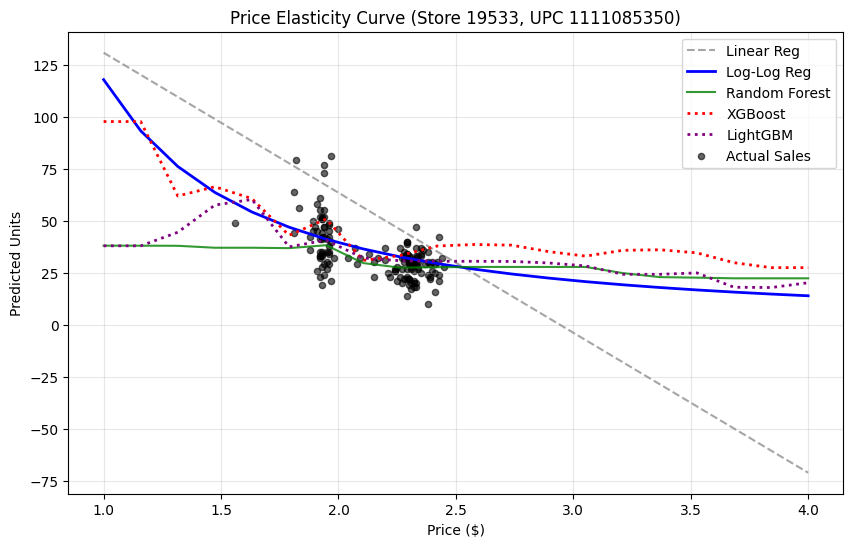

In [8]:
# Setup Data (One Store, One UPC, varying Price)
unique_stores = df['STORE_NUM'].unique()
unique_upcs = df['UPC'].unique()

sample_store = unique_stores[5]
sample_upc = unique_upcs[3]
prices = np.linspace(1.0, 4.0, 20)

# retrieve base price using the last one in the data
sample_base_price = df[(df['STORE_NUM'] == sample_store) & (df['UPC'] == sample_upc)]['BASE_PRICE'].iloc[-1]
discounts = (sample_base_price - prices) / sample_base_price

if with_UPC:
  # ['STORE_NUM', 'UPC', 'PRICE', 'BASE_PRICE', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'WEEK_NUM']
  curve_df = pd.DataFrame({
      'STORE_NUM': [sample_store] * len(prices),
      'UPC': [sample_upc] * len(prices),
      'PRICE': prices,
      'DISCOUNT': discounts,
      'FEATURE': 0, 'DISPLAY': 0, 'TPR_ONLY': 0,
      'WEEK_NUM': 20
  })
else:
  # ['STORE_NUM', 'PRICE', 'DISCOUNT', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE', 'WEEK_NUM']
  sample_upc_attributes = df[df['UPC'] == sample_upc][['MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE']].drop_duplicates()

  # Find the attributes of that sampled UPC
  if not sample_upc_attributes.empty:
      sample_manufacturer = sample_upc_attributes['MANUFACTURER'].iloc[0]
      sample_sub_category = sample_upc_attributes['SUB_CATEGORY'].iloc[0]
      sample_product_size = sample_upc_attributes['PRODUCT_SIZE'].iloc[0]
  curve_df = pd.DataFrame({
      'STORE_NUM': [sample_store] * len(prices),
      'PRICE': prices,
      'DISCOUNT': discounts,
      'FEATURE': 0, 'DISPLAY': 0, 'TPR_ONLY': 0,
      'MANUFACTURER': sample_manufacturer,
      'SUB_CATEGORY': sample_sub_category,
      'PRODUCT_SIZE': sample_product_size,
      'WEEK_NUM': 20
  })

# Align OHE (Linear & RF)
curve_ohe = pd.get_dummies(curve_df, columns=categorical_columns, drop_first=True)
ohe_cols = X_ohe.columns # Define ohe_cols from the training data columns
curve_ohe = curve_ohe.reindex(columns=ohe_cols, fill_value=0)

# Align Log (Log-Log)
curve_log = curve_ohe.copy()
curve_log['PRICE'] = np.log(curve_df['PRICE'])      # Log Transform Price

# Align Categorical (XGB/LGBM)
curve_cat = curve_df.copy()

for col in categorical_columns:
    curve_cat[col] = curve_cat[col].astype('category')

# Get Predictions
p_lin = lr.predict(curve_ohe)
p_log = np.exp(lr_log.predict(curve_log)) # Remember to Exp()!
p_rf = rf.predict(curve_ohe)
p_xgb = xg_reg.predict(curve_cat)
p_lgbm = lgbm_reg.predict(curve_cat)

# Plot
import matplotlib.pyplot as plt # Import matplotlib
plt.figure(figsize=(10, 6))
plt.plot(prices, p_lin, label='Linear Reg', linestyle='--', color='gray', alpha=0.7)
plt.plot(prices, p_log, label='Log-Log Reg', linestyle='-', color='blue', linewidth=2)
plt.plot(prices, p_rf, label='Random Forest', linestyle='-', color='green', alpha=0.8)
plt.plot(prices, p_xgb, label='XGBoost', linestyle=':', color='red', linewidth=2)
plt.plot(prices, p_lgbm, label='LightGBM', linestyle=':', color='purple', linewidth=2)

# ADDED: Plot actual data points
actual_data = df[(df['STORE_NUM'] == sample_store) & (df['UPC'] == sample_upc)]
plt.scatter(actual_data['PRICE'], actual_data['UNITS'], label='Actual Sales', color='black', alpha=0.6, s=20)

plt.title(f'Price Elasticity Curve (Store {sample_store}, UPC {sample_upc})')
plt.xlabel('Price ($)')
plt.ylabel('Predicted Units')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Annex 2A: Preparing feature inputs used for future predictions
In order to predict, we need to create input features with varying prices and then use `final_model` to perform predictions

In [9]:
# Forecast future sales of store 367 the week following the last week in the data for the prices ranging from 1.5 to 5.5 with a given increment
predict_prices = np.arange(1.0, 4.0, 0.25)

predict_store = 367
week = 25
# Prepare the list of UPCs
predict_upcs = df['UPC'].unique()
predict_input_rows = []

print(df[df['UPC'] == predict_upcs[0]][['MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE']].drop_duplicates())

for u in predict_upcs:
  # Retrieve base price and attributes for the current UPC
  reference_base_price = df[(df['STORE_NUM'] == predict_store) & (df['UPC'] == u)]['BASE_PRICE'].iloc[-1]
  upc_attributes = df[df['UPC'] == u][['MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE']].drop_duplicates()

  for p in predict_prices:
    discount = (reference_base_price - p) / reference_base_price

    for f in [0,1]:
      for d in [0,1]:
        # Base dictionary for common features
        if with_UPC:
          # ['STORE_NUM', 'UPC', 'PRICE', 'DISCOUNT', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'WEEK_NUM']
          row = {
              'STORE_NUM': predict_store,
              'UPC': u,
              'PRICE': p,
              'DISCOUNT': discount,
              'FEATURE': f, 'DISPLAY': d, 'TPR_ONLY': 0,
              'WEEK_NUM': week
          }
        else:
          # ['STORE_NUM', 'PRICE', 'DISCOUNT', 'FEATURE', 'DISPLAY', 'TPR_ONLY', 'MANUFACTURER', 'SUB_CATEGORY', 'PRODUCT_SIZE', 'WEEK_NUM']

          # Find the attributes of that UPC
          if not upc_attributes.empty:
              upc_manufacturer = upc_attributes['MANUFACTURER'].iloc[0]
              upc_sub_category = upc_attributes['SUB_CATEGORY'].iloc[0]
              upc_product_size = upc_attributes['PRODUCT_SIZE'].iloc[0]

          row = {
              'STORE_NUM': predict_store,
              'UPC': u,
              'PRICE': p,
              'DISCOUNT': discount,
              'FEATURE': f, 'DISPLAY': d, 'TPR_ONLY': 0,
              'MANUFACTURER': upc_manufacturer, 'SUB_CATEGORY': upc_sub_category, 'PRODUCT_SIZE': upc_product_size,
              'WEEK_NUM': week
          }
        predict_input_rows.append(row)

# Create a DataFrame from the list of rows
f_df = pd.DataFrame(predict_input_rows)

f_df.head(25)

    MANUFACTURER       SUB_CATEGORY PRODUCT_SIZE
0  PRIVATE LABEL  ALL FAMILY CEREAL        12 OZ


,STORE_NUM,UPC,PRICE,DISCOUNT,FEATURE,DISPLAY,TPR_ONLY,MANUFACTURER,SUB_CATEGORY,PRODUCT_SIZE,WEEK_NUM
0,367,1111085319,1.00,0.397590,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
1,367,1111085319,1.00,0.397590,0,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
2,367,1111085319,1.00,0.397590,1,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
3,367,1111085319,1.00,0.397590,1,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
4,367,1111085319,1.25,0.246988,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
5,367,1111085319,1.25,0.246988,0,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
6,367,1111085319,1.25,0.246988,1,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
7,367,1111085319,1.25,0.246988,1,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
8,367,1111085319,1.50,0.096386,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25
9,367,1111085319,1.50,0.096386,0,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25


### Annex 2B: Predicting the future demands
We will not predict the future demands based on different prices for the selected store

In [10]:
# repeat the same transformation process (for the category columns) and then predict the sales
f_X = f_df.copy()

# Ensure f_X has the exact same columns and order as the training data X_cat
f_X = f_X[X_cat.columns]

# Ensure categorical columns have the same categories as the training data
for col in categorical_columns:
    f_X[col] = f_X[col].astype('category')

f_df['PREDICTED_UNITS'] = final_model.predict(f_X)

print("\nForecast Matrix (with Feature split):")

f_df.head(25)


Forecast Matrix (with Feature split):


,STORE_NUM,UPC,PRICE,DISCOUNT,FEATURE,DISPLAY,TPR_ONLY,MANUFACTURER,SUB_CATEGORY,PRODUCT_SIZE,WEEK_NUM,PREDICTED_UNITS
0,367,1111085319,1.00,0.397590,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,55.030299
1,367,1111085319,1.00,0.397590,0,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,100.255328
2,367,1111085319,1.00,0.397590,1,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,104.413675
3,367,1111085319,1.00,0.397590,1,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,137.282986
4,367,1111085319,1.25,0.246988,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,34.997575
5,367,1111085319,1.25,0.246988,0,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,69.122670
6,367,1111085319,1.25,0.246988,1,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,50.536795
7,367,1111085319,1.25,0.246988,1,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,87.836007
8,367,1111085319,1.50,0.096386,0,0,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,21.140187
9,367,1111085319,1.50,0.096386,0,1,0,PRIVATE LABEL,ALL FAMILY CEREAL,12 OZ,25,50.295854


### Annex 2C: Price optimization
Calculate expected revenues and find optimal prices under different settings of `FEATURE` and `DISPLAY` and export the output into csv file.

In [11]:
from google.colab import files

# Calculate the revenue for each entry
f_df['REVENUE'] = f_df['PRICE'] * f_df['PREDICTED_UNITS']

# Calculate the optimal price for each UPC and FEATURE combination that maximizes REVENUE
optimal_revenue_prices = f_df.loc[f_df.groupby(['UPC', 'FEATURE', 'DISPLAY'])['REVENUE'].idxmax()]

# Display the results
print("Optimal Prices for Maximum Weekly Revenue:")
# we first select only the important columns and then sort the results
df_optimal_prices = optimal_revenue_prices[['STORE_NUM', 'UPC', 'PRICE', 'FEATURE', 'DISPLAY', 'PREDICTED_UNITS', 'REVENUE']].sort_values(['UPC', 'FEATURE'])
display(df_optimal_prices)

filename = 'optimal_prices.csv'
df_optimal_prices.to_csv(filename, index=False)
files.download(filename)


Optimal Prices for Maximum Weekly Revenue:


,STORE_NUM,UPC,PRICE,FEATURE,DISPLAY,PREDICTED_UNITS,REVENUE
0,367,1111085319,1.00,0,0,55.030299,55.030299
29,367,1111085319,2.75,0,1,45.834968,126.046161
2,367,1111085319,1.00,1,0,104.413675,104.413675
47,367,1111085319,3.75,1,1,55.362374,207.608901
100,367,1111085345,1.25,0,0,42.829148,53.536436
125,367,1111085345,2.75,0,1,42.411790,116.632424
98,367,1111085345,1.00,1,0,118.247611,118.247611
143,367,1111085345,3.75,1,1,48.681493,182.555600
152,367,1111085350,1.50,0,0,53.395523,80.093284
153,367,1111085350,1.50,0,1,92.442867,138.664300


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Annex 2D: Pivot Table for combined features to be used for optimization

Pivot the prepared data to create a new table where each row represents a unique UPC, and the columns represent the four combinations of 'FEATURE' and 'DISPLAY' (0,0), (0,1), (1,0), and (1,1). The values in these columns will be the corresponding optimal revenues. This format will be exported to Excel as inputs for an optimization model for optimal price and strategy (`FEATURE` and `DISPLAY`) selections.


In [12]:
revenue_data = optimal_revenue_prices[['UPC', 'FEATURE', 'DISPLAY', 'REVENUE']].copy()
revenue_data['FEATURE_DISPLAY_COMBINATION'] = 'FEATURE=' + revenue_data['FEATURE'].astype(str) + ', DISPLAY=' + revenue_data['DISPLAY'].astype(str)
revenue_table = revenue_data.pivot_table(index='UPC', columns='FEATURE_DISPLAY_COMBINATION', values='REVENUE')
revenue_table


FEATURE_DISPLAY_COMBINATION,"FEATURE=0, DISPLAY=0","FEATURE=0, DISPLAY=1","FEATURE=1, DISPLAY=0","FEATURE=1, DISPLAY=1"
UPC,,,,
1111085319,55.030299,126.046161,104.413675,207.608901
1111085345,53.536436,116.632424,118.247611,182.555600
1111085350,80.093284,138.664300,149.933596,197.015048
1600027527,63.997215,164.816482,167.149950,252.480439
1600027528,79.460644,164.011425,219.238004,243.621476
1600027564,60.099040,167.616797,153.071146,247.781225
3800031829,114.774222,202.003819,213.210308,269.550609
3800031838,120.654771,207.484899,219.201423,281.320115
3800039118,113.813994,212.041016,203.567262,273.993918


In [13]:

from google.colab import files

# 1. Display the revenue_table DataFrame
print("\nRevenue Table:")
display(revenue_table.head())

# 2. Save the revenue_table DataFrame to a CSV file
filename = 'revenue_table.csv'
revenue_table.to_csv(filename, index=True)

# 3. Download the 'revenue_table.csv' file
files.download(filename)


Revenue Table:


FEATURE_DISPLAY_COMBINATION,"FEATURE=0, DISPLAY=0","FEATURE=0, DISPLAY=1","FEATURE=1, DISPLAY=0","FEATURE=1, DISPLAY=1"
UPC,,,,
1111085319,55.030299,126.046161,104.413675,207.608901
1111085345,53.536436,116.632424,118.247611,182.555600
1111085350,80.093284,138.664300,149.933596,197.015048
1600027527,63.997215,164.816482,167.149950,252.480439
1600027528,79.460644,164.011425,219.238004,243.621476


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>